This notebook provides the code for creating a model template for usage in the Vertex AI experimentation framework outlined below. The approach is simple:
- Load data 
- Instantiate model with desired architecture
- Fit normalizers 
- Compile model (but do not train)
- Upload model and model features to cloud storage

The directory structure for the custom model can be seen in the README file. 

As a reminder, we  take this approach of pre-building a model and uploading it to cloud storage to allow our Vertex AI experimentation framework to be model agnostic. By separating the defining of the model from the training of the model, the training application is model agnostic and can be reused for any architecture, allowing for faster experimentation. We load the same data file here because we have to fit the normalizer layers of the model to the training data before uploading. **Future iterations to this experimentation framework should try to shift the fitting of normalizing layers to the training application as well, allowing for even faster iteration since large datasets will not need to be loading to create a model template.**

# Load Packages, Variables

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf


from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

2024-01-04 00:12:24.127362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-04 00:12:24.293894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-04 00:12:24.295974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version: 2.7.0


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

##COMMON VARIABLES
#DATA WINDOW
train_start = '2023-05-01'
train_end = '2023-10-31'
test_start = '2023-11-01'
test_end = '2023-11-30'
#MODEL PARAMETERS 
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0001
BATCH_SIZE = 10000 #ficc_keras_utils.BATCH_SIZE
NUM_EPOCHS = 75 #ficc_keras_utils.NUM_EPOCHS
DROPOUT = 0.1 #ficc_keras_utils.DROPOUT

##NOTEBOOK SPECIFIC VARIABLES 
# target_variable = 'new_ys_diff'
# target_variable = 'new_ys' 
target_variable = 'new_ys' 
NUM_FEATURES = 6
SEQUENCE_LENGTH = 5

In [3]:
print(train_start ,
train_end ,
test_start ,
test_end)

2023-05-01 2023-10-31 2023-11-01 2023-11-30


In [4]:
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('gs://automated_training/encoders.pkl') as f:
    encoders = pickle.load(f)
fmax = {key: len(value.classes_) for key, value in encoders.items()}

/home/jupyter/.local/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Load Data and Train NN

In [5]:
BINARY_FEATURES = ['callable',
          'sinking',
          'zerocoupon',
          'is_non_transaction_based_compensation',
          'is_general_obligation',
          'callable_at_cav',
          'extraordinary_make_whole_call',
          'make_whole_call',
          'has_unexpired_lines_of_credit',
          'escrow_exists']

CATEGORICAL_FEATURES = ['rating',
                        'incorporated_state_code',
                        'trade_type',
                        'purpose_class',
                        'max_ys_ttypes',
                        'min_ys_ttypes',
                        'max_qty_ttypes',
                        'min_ago_ttypes',
                        'D_min_ago_ttypes',
                        'P_min_ago_ttypes',
                        'S_min_ago_ttypes']

NON_CATEGORICAL_FEATURES = ['quantity',
                     'days_to_maturity',
                     'days_to_call',
                     'coupon',
                     'issue_amount',
                     'last_seconds_ago',
                     'last_yield_spread',
                     'days_to_settle',
                     'days_to_par',
                     'maturity_amount',
                     'issue_price',
                     'orig_principal_amount',
                     'max_amount_outstanding',
                     'accrued_days',
                     'days_in_interest_payment',
                     'A/E',
                     'ficc_treasury_spread',
                     'max_ys_ys',
                     'max_ys_ago',
                     'max_ys_qdiff',
                     'min_ys_ys',
                     'min_ys_ago',
                     'min_ys_qdiff',
                     'max_qty_ys',
                     'max_qty_ago',
                     'max_qty_qdiff',
                     'min_ago_ys',
                     'min_ago_ago',
                     'min_ago_qdiff',
                     'D_min_ago_ys',
                     'D_min_ago_ago',
                     'D_min_ago_qdiff',
                     'P_min_ago_ys',
                     'P_min_ago_ago',
                     'P_min_ago_qdiff',
                     'S_min_ago_ys',
                     'S_min_ago_ago',
                     'S_min_ago_qdiff']

In [8]:
def load_data_from_pickle(path, folder = 'isaac_data'):
    if os.path.isfile(path):
        print('File available, loading pickle')
        with open(path, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f'File not available, downloading from cloud storage and saving to {path}')
        fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
        gc_path = os.path.join(folder, path)
        print(gc_path)
        with fs.open(gc_path) as gf:
            data = pd.read_pickle(gf)
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    return data

In [9]:
%time processed_data = load_data_from_pickle('similar_trades_bucket_df.pkl', folder = 'ficc-model-experiments/data')

File not available, downloading from cloud storage and saving to similar_trades_bucket_df.pkl
ficc-model-experiments/data/similar_trades_bucket_df.pkl
CPU times: user 8min 1s, sys: 1min 4s, total: 9min 5s
Wall time: 13min 40s


In [10]:
processed_data['trade_history'].apply(lambda x: x.shape).value_counts()

(5, 6)    7376363
Name: trade_history, dtype: int64

In [13]:
processed_data['similar_trade_history_5_calc'].apply(lambda x: x.shape).value_counts()

(5, 6)    7376363
Name: similar_trade_history_5_calc, dtype: int64

In [14]:
processed_data['similar_trade_history_5_mat'].apply(lambda x: x.shape).value_counts()

(5, 6)    7376363
Name: similar_trade_history_5_mat, dtype: int64

In [15]:
processed_data.trade_date.min(), processed_data.trade_date.max()

(Timestamp('2023-05-01 00:00:00'), Timestamp('2023-12-08 00:00:00'))

In [16]:
na = processed_data[BINARY_FEATURES+CATEGORICAL_FEATURES+NON_CATEGORICAL_FEATURES+['new_ys']].isna().sum()
na[na>0]

Series([], dtype: int64)

In [17]:
train_filter = (processed_data.trade_date <= train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <= test_end)
                                                            
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

Training data start: 2023-05-01 00:00:00, end: 2023-10-31 00:00:00
Test data start: 2023-11-01 00:00:00, end: 2023-11-30 00:00:00


In [18]:
def create_input(df, trade_history_col, additional_sequence_cols):
    global encoders
    datalist = []
        
    for col in additional_sequence_cols:
        datalist.append(np.stack(df[col].to_numpy()))
        
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))
    
    noncat_and_binary = []
    for f in NON_CATEGORICAL_FEATURES + BINARY_FEATURES:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist


def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, additional_sequence_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    num_additional_sequences = len(additional_sequence_cols)
    
    additional_sequence_lengths = [train_dataframe[x][0].shape[0] for x in additional_sequence_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'additional_sequence_cols':additional_sequence_cols, 
           'additional_sequence_lengths':additional_sequence_lengths, 
           'num_additional_sequences':num_additional_sequences}
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input(train_dataframe.drop(val_idx, axis=0), trade_history_col, additional_sequence_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input(train_dataframe.iloc[val_idx], trade_history_col, additional_sequence_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input(test_dataframe, trade_history_col, additional_sequence_cols)
    y_test = test_dataframe[target_variable]    
    with tf.device('/cpu:0'):
        # Normalization layer for the yield history
        additional_normalizers = []
        for i in range(num_additional_sequences):
            additional_normalizers.append(Normalization(name=f'normalizer_{additional_sequence_cols[i]}'))
            additional_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)

        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[num_additional_sequences],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[num_additional_sequences+2], batch_size = BATCH_SIZE)

    normalizers = {'additional_normalizers': additional_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx

In [19]:
def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

In [29]:
def generate_model(TRADE_SEQUENCE_LENGTH, additional_sequence_cols, additional_sequence_lengths, num_additional_sequences,
                      additional_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []

    ############## INPUT BLOCK ###################
    for i in range(num_additional_sequences):
        inputs.append(layers.Input(name=f"{additional_sequence_cols[i]}", 
                                           shape=(additional_sequence_lengths[i], NUM_FEATURES), 
                                           dtype = tf.float32))
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CATEGORICAL_FEATURES + BINARY_FEATURES),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_additional_sequences+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_additional_sequences]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)

    ####################################################
    
    ############## YIELD HISTORY MODEL #################
    additional_sequence_ouputs = []
    for i in range(num_additional_sequences):
        lstm1 = layers.Bidirectional(layers.LSTM(50, 
                                 activation='tanh',
                                 input_shape=(additional_sequence_lengths[i], 6),
                                 return_sequences = True,
                                 name=f'LSTM_{additional_sequence_cols[i]}'))
        lstm2 = layers.Bidirectional(layers.LSTM(100, 
                                 activation='tanh',
                                 input_shape=(additional_sequence_lengths[i], 50),
                                 return_sequences = True,
                                 name=f'LSTM_2_{additional_sequence_cols[i]}'))

        features = lstm1(additional_normalizers[i](inputs[i]))
        features = lstm2(features)
        features = layers.Flatten(name=f'flatten_{additional_sequence_cols[i]}')(features)
        
#         attention_sequence = layers.Dense(200, activation='relu', name=f'attention_dense_{additional_sequence_cols[i]}')(target_attention_input)
#         attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
#         attention = layers.Activation('softmax')(attention)

#         context_vector = layers.Dot(axes=[1, 1])([features, attention])
#         context_vector = layers.Flatten(name=f'context_vector_flatten_{additional_sequence_cols[i]}')(context_vector)

#         features = layers.Dense(100, 
#                                         activation='relu')(context_vector)
        
        
        
        
        additional_sequence_ouputs.append(layers.Dense(100, activation='relu')(features))
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

    ####################################################

    feed_forward_input = layers.concatenate(additional_sequence_ouputs+[reference_output, trade_history_output])

    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)
    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model

def train_model(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):
    tf.keras.backend.clear_session()
    gc.collect()

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    additional_sequence_cols = params.get('additional_sequence_cols')
    additional_sequence_lengths = params.get('additional_sequence_lengths')
    num_additional_sequences = params.get('num_additional_sequences')
      
    additional_normalizers = normalizers.get('additional_normalizers')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    model = generate_model_new(TRADE_SEQUENCE_LENGTH, additional_sequence_cols, additional_sequence_lengths, num_additional_sequences, 
                               additional_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # time_callback,
        CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model



In [21]:
def train_model_new(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):
    tf.keras.backend.clear_session()
    gc.collect()

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    additional_sequence_cols = params.get('additional_sequence_cols')
    additional_sequence_lengths = params.get('additional_sequence_lengths')
    num_additional_sequences = params.get('num_additional_sequences')
      
    additional_normalizers = normalizers.get('additional_normalizers')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    model = generate_model_new(TRADE_SEQUENCE_LENGTH, additional_sequence_cols, additional_sequence_lengths, num_additional_sequences, 
                               additional_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # time_callback,
        CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model



In [47]:
trade_history_col = 'trade_history'
# additional_sequence_cols = ['similar_trade_history_2']
# additional_sequence_cols = ['similar_trade_history_5']
additional_sequence_cols = []
# additional_sequence_cols = ['similar_trade_history_2', 'similar_trade_history_5']
# additional_sequence_cols = ['similar_trade_history_5_calc']
# additional_sequence_cols = ['similar_trade_history_5_mat']

In [48]:
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, additional_sequence_cols)

TRAINING DATA: N = 5168228, MIN DATE = 2023-05-01 00:00:00, MAX DATE = 2023-10-31 00:00:00
VALIDATION DATA: N = 574247, MIN DATE = 2023-05-01 00:00:00, MAX DATE = 2023-10-31 00:00:00
TEST DATA: N = 1288216, MIN DATE = 2023-11-01 00:00:00, MAX DATE = 2023-11-30 00:00:00


In [49]:
params

{'TRADE_SEQUENCE_LENGTH': 5,
 'additional_sequence_cols': [],
 'additional_sequence_lengths': [],
 'num_additional_sequences': 0}

In [50]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape)

14
(5168228, 5, 6)
(5168228, 1, 3)
(5168228, 48)
(5168228,)
(5168228,)
(5168228,)
(5168228,)
(5168228,)
(5168228,)
(5168228,)
(5168228,)
(5168228,)
(5168228,)
(5168228,)


In [51]:
TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
additional_sequence_cols = params.get('additional_sequence_cols')
additional_sequence_lengths = params.get('additional_sequence_lengths')
num_additional_sequences = params.get('num_additional_sequences')

additional_normalizers = normalizers.get('additional_normalizers')
trade_history_normalizer = normalizers.get('trade_history_normalizer')
noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')

In [52]:
# ENSEMBLE_SIZE = 4
# models = []
# for i in range(ENSEMBLE_SIZE):
#     models.append(generate_model(TRADE_SEQUENCE_LENGTH, additional_sequence_cols, additional_sequence_lengths, num_additional_sequences,
#                   additional_normalizers, trade_history_normalizer, noncat_binary_normalizer))
# input_layer = models[0].input
# output_list = [model(input_layer) for model in models]
# # output_concat = layers.Concatenate()(output_list)
# ensemble_base = keras.Model(inputs = input_layer, outputs = output_list) # + [output_concat])
# ensemble_base.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#           loss=[keras.losses.MeanAbsoluteError() for _ in range(ENSEMBLE_SIZE)])

# ensemble_base.save('gs://ficc-model-experiments/similar_trade_history_5yr_2LSTM_ensemble/model')

In [53]:
model = generate_model(TRADE_SEQUENCE_LENGTH, additional_sequence_cols, additional_sequence_lengths, num_additional_sequences,
                      additional_normalizers, trade_history_normalizer, noncat_binary_normalizer)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

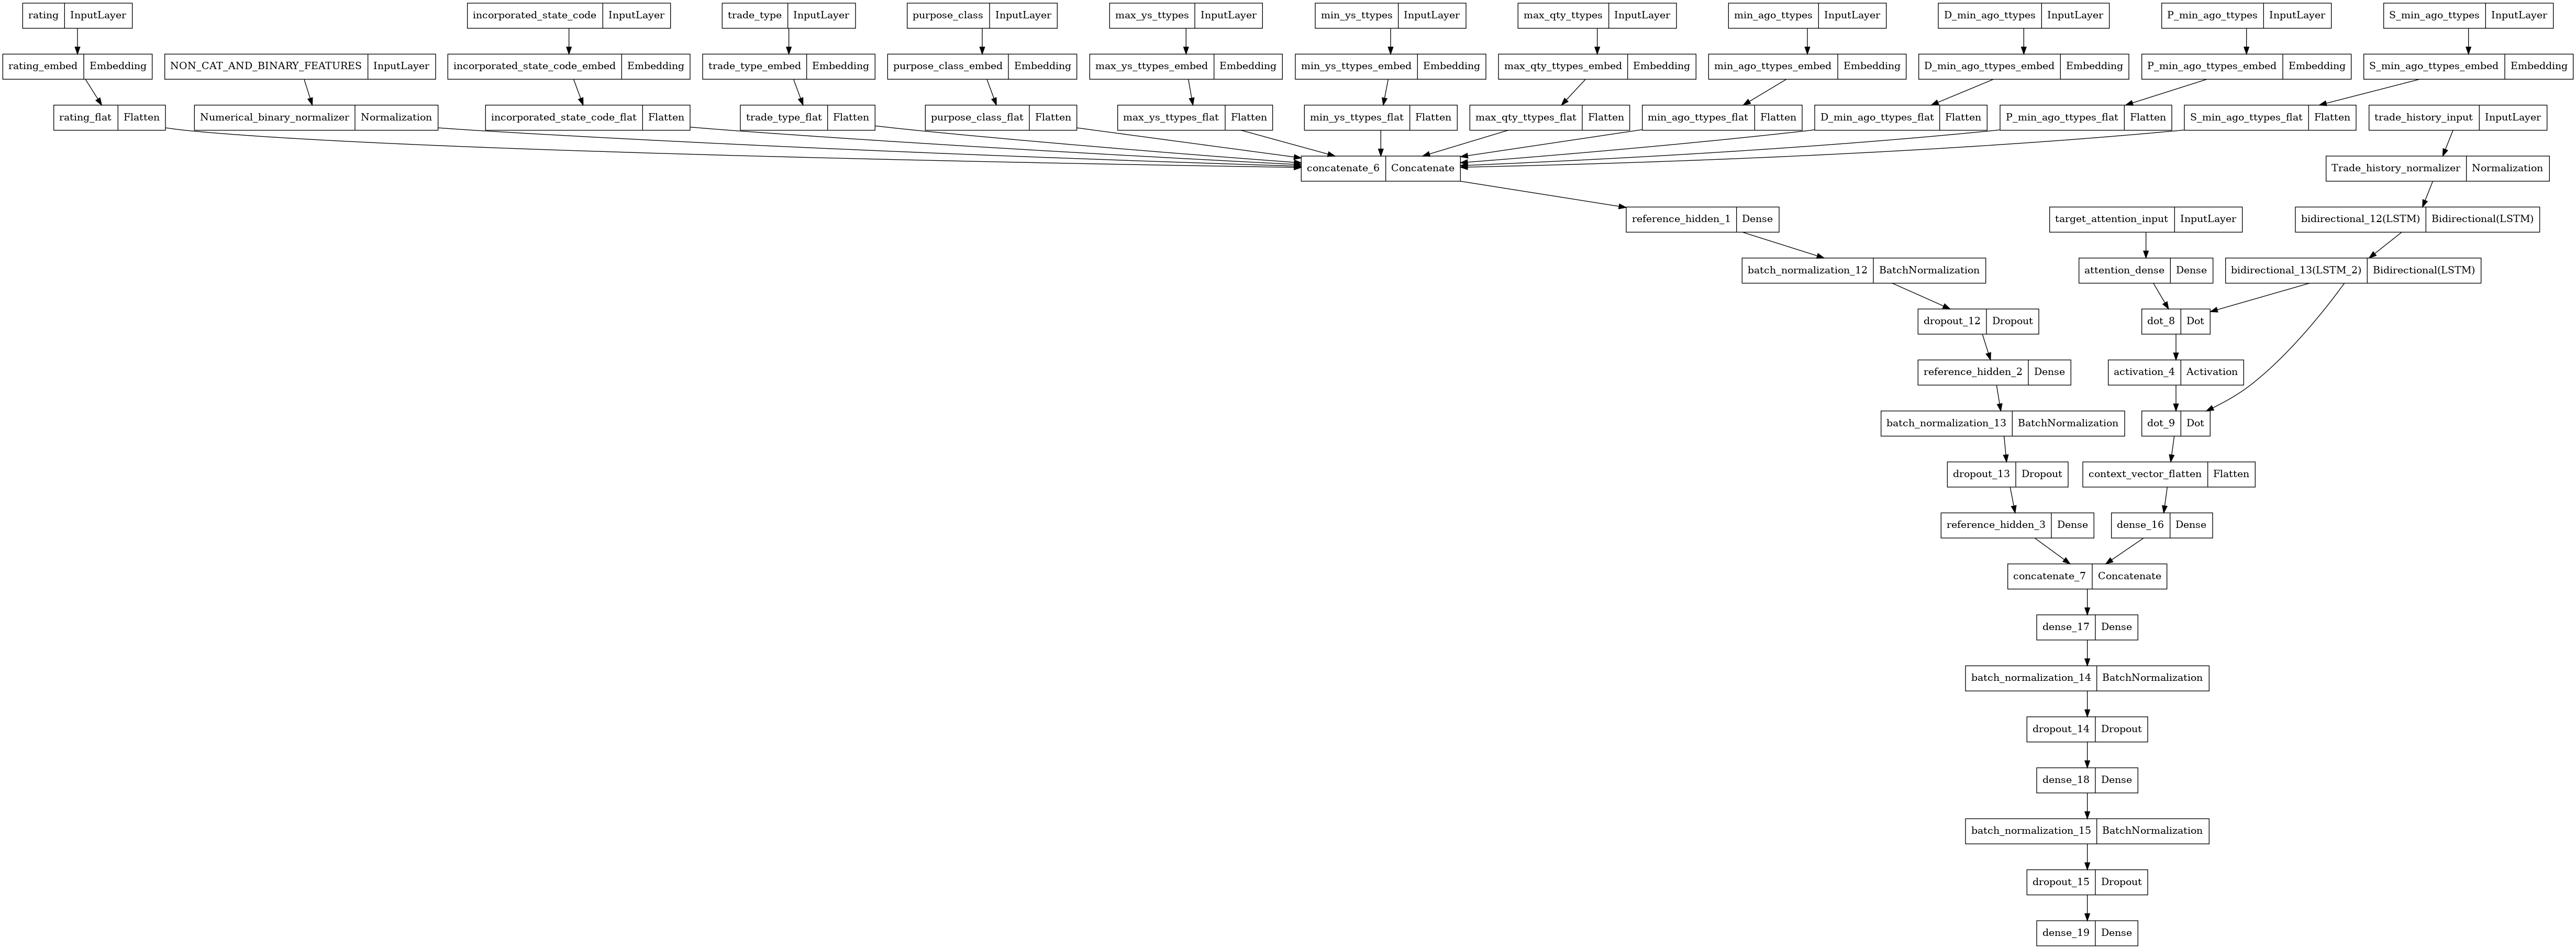

In [54]:
keras.utils.plot_model(model)

Save both the model and the model features:

In [55]:
model.save('gs://ficc-model-experiments/model-templates/similar-trades-bucket/baseline/model')
# model.save('gs://ficc-model-experiments/model-templates/similar-trades-bucket/5yr_mat_2LSTM/model')

INFO:tensorflow:Assets written to: gs://ficc-model-experiments/model-templates/similar-trades-bucket/baseline/model/assets


INFO:tensorflow:Assets written to: gs://ficc-model-experiments/model-templates/similar-trades-bucket/baseline/model/assets


In [56]:
import json

d = {'BINARY_FEATURES': BINARY_FEATURES, 
     'CATEGORICAL_FEATURES': CATEGORICAL_FEATURES, 
     'NON_CATEGORICAL_FEATURES': NON_CATEGORICAL_FEATURES,
    'ADDITIONAL_SEQUENCES': additional_sequence_cols}
with fs.open('gs://ficc-model-experiments/model-templates/similar-trades-bucket/baseline/model_features.json', 'w') as f:
# with fs.open('gs://ficc-model-experiments/model-templates/similar-trades-bucket/5yr_mat_2LSTM/model_features.json', 'w') as f:
    json.dump(d, f)